In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import re
import copy
import math

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [3]:
def openData():
    """
    Opens the csv with the data and cleans the dataset and returns a dataframe.
    """
    # Sort data in descending order by page visibility. This ensures duplicates without page followers are dropped.
#     data = pd.read_csv("../data/facebook_data_cleaned.csv").sort_values('visibility', ascending=False)
#     data = data.drop_duplicates(['altmetric_id'], keep='first')

    data = pd.read_csv("../data/small_data.csv")
    
    data['fb_wall_urls'] = data['fb_wall_urls'].apply(lambda x: eval(x))
    
    def func(inp):
        if inp is nan:
            return inp
        try:
            res = eval(inp)
        except:
            res = [inp]
        return res
    
    data['subjects'] = data['subjects'].map(func)
    data['scopus_subjects'] = data['scopus_subjects'].map(func)
    data['publisher_subjects'] = data['publisher_subjects'].map(func)
    
    data['fb_wall_count'] = data['fb_wall_count'].astype(int)
    
    return data


In [4]:
data = openData()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9334 entries, 0 to 9333
Data columns (total 19 columns):
altmetric_id          9334 non-null float64
title                 9273 non-null object
subjects              4995 non-null object
abstract              6041 non-null object
pubdate               9334 non-null object
fb_wall_count         9334 non-null int32
scopus_subjects       5824 non-null object
publisher_subjects    5659 non-null object
fb_wall_urls          9334 non-null object
shares                9334 non-null int64
visibility            9334 non-null int64
total_like            9334 non-null int64
total_love            9334 non-null int64
total_wow             9334 non-null int64
total_haha            9334 non-null int64
total_sad             9334 non-null int64
total_angry           9334 non-null int64
total_reactions       9334 non-null int64
all_subjects          9334 non-null object
dtypes: float64(1), int32(1), int64(9), object(8)
memory usage: 1.3+ MB


In [6]:
# (data['shares'] + data['total_like'] + data['total_love'] + data['total_wow'] + data['total_haha'] + data['total_sad'] + data['total_angry']).sum()

In [7]:
df = copy.deepcopy(data)

## Let's work out the weight of the reactions

We use a similar concept to TF-IDF: the weight of a reaction is inversely proportional to the frequency with which the reaction appears in the entire set


In [8]:
# # Compute weights for each reaction 
# weights = dict()
# # weights are similar to inverse-document frequency

# for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
#     weights[feat] = np.log(len(df)/(df[feat].apply(lambda x: 1 if x>0 else 0).sum()))

# # Compute raw sum of reactions
# df['sum_reacts'] =  df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

# # Weight the raw reactions
# for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
#     df[feat] = (1 + df[feat] / df['sum_reacts']).apply(np.log) * weights[feat]
    
# # Compute total reactions for each article with weighted values
# df['total_reacts'] = df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

# # Compute intensity of each article
# df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']

# # Compute diversity of each article
# df['diversity'] = ((df['total_love'].apply(lambda x: 1 if x>0 else 0) + df['total_wow'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_haha'].apply(lambda x: 1 if x>0 else 0) + df['total_sad'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_angry'].apply(lambda x: 1 if x>0 else 0)) - 1) / 4

# # Compute Div-int index
# df['divint_index'] = df['diversity'] * df['intensity']

In [9]:
weights = dict()
# weights are similar to inverse-document frequency

for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    weights[feat] = np.log(len(df)/(df[feat].apply(lambda x: 1 if x>0 else 0).sum()))

In [10]:
print("PERCENT OF ARTICLES THAT HAVE EACH REACTION")
print("-------------------------------------------")
for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    print(feat, ":", 100 * df[feat].apply(lambda x: 1 if x>0 else 0).sum()/len(df))

PERCENT OF ARTICLES THAT HAVE EACH REACTION
-------------------------------------------
total_like : 98.66080994214698
total_love : 75.66959502892651
total_wow : 48.67152346260981
total_haha : 13.081208485108206
total_sad : 17.409470752089135
total_angry : 11.57060209985001


In [11]:
# for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
#     df[feat] = np.log(df[feat] + 1)
#     if feat=='total_like':
#         df[feat] = np.log(df[feat] + 1)
# #         df[feat] = df[feat].apply(lambda x: x**(1/3))
#     df[feat][np.isneginf(df[feat])] = 0
        
df['sum_reacts'] =  df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

for feat in ['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']:
    df[feat] = (1 + df[feat] / df['sum_reacts']).apply(np.log) * weights[feat]

In [12]:
df['total_reacts'] = df['total_like'] + df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']

In [13]:
df['tot_pos'] = (df['total_love'] + ((df['total_wow'] * df['total_love']) /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']

df['tot_neg'] = (df['total_angry'] + df['total_sad'] + ((df['total_wow'] * (df['total_angry'] + df['total_sad'])) /
                                        (df['total_love'] + df['total_sad'] + df['total_angry']))) / df['total_reacts']


# df['tot_pos'] = (df['total_love'] + df['total_like'] + (df['total_wow'] * (df['total_love'] + df['total_like']) /
#                                      (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_neg'] = (df['total_angry'] + df['total_sad'] + (df['total_wow'] * (df['total_angry'] + df['total_sad']) /
#                                                         (df['total_love'] + df['total_sad'] + df['total_angry'] + df['total_like']))) / df['total_reacts']

# df['tot_pos'] = df['total_love'] / (df['total_love'] + df['total_sad'] + df['total_angry'])

# df['tot_neg'] = (df['total_angry'] + df['total_sad']) / (df['total_love'] + df['total_sad'] + df['total_angry'])

In [14]:
df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']
# df['intensity'] = (df['total_love'] + df['total_wow'] + df['total_haha'] + df['total_sad'] + df['total_angry']) / df['total_reacts']

In [15]:
# def f(x):
#     if x > 0:
#         return 1
#     elif x == 0:
#         return 0
#     return -1

df['valence'] = df['tot_pos'] - df['tot_neg']
df['valence'] = df['valence'].apply(lambda x: 1 if x >= 0 else -1)

In [16]:
df['polarity'] = 1 - 4 * abs(np.pi/4 - np.arctan(df['total_angry']/df['total_love'])) / np.pi

df['polarity'] *= df['intensity']

C:\Users\colefreeman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arctan
  """Entry point for launching an IPython kernel.


In [17]:
# df['diversity'] = ((df['total_love'].apply(lambda x: 1 if x>0 else 0) + df['total_wow'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_haha'].apply(lambda x: 1 if x>0 else 0) + df['total_sad'].apply(lambda x: 1 if x>0 else 0) + 
#                    df['total_angry'].apply(lambda x: 1 if x>0 else 0)) - 1) / 4

df['diversity'] = (df['total_love'].apply(lambda x: 1 if x>0 else 0) + df['total_wow'].apply(lambda x: 1 if x>0 else 0) + 
                   df['total_haha'].apply(lambda x: 1 if x>0 else 0) + df['total_sad'].apply(lambda x: 1 if x>0 else 0) + 
                   df['total_angry'].apply(lambda x: 1 if x>0 else 0) + df['total_like'].apply(lambda x: 1 if x>0 else 0) - 1) / 5

df['divint_index'] = df['diversity'] * df['intensity']

In [18]:
# df['rxn_var'] = df[['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']].var(axis=1)

# # Apply the sigmoid function
# df['rxn_var'] = df['rxn_var'].apply(lambda x: 1 / (1 + math.exp(-x)))

# df['div_sigm'] = df['diversity'] * (df['rxn_var']**(-1))

# df['div_sigm'] /= df['div_sigm'].max()

In [19]:
# df['diversity'] /= df['diversity'].max()

In [20]:
# df['div_sigm'].describe()

In [22]:
df['divint_index'].describe()

count    9334.000000
mean        0.264115
std         0.198132
min         0.000000
25%         0.139068
50%         0.184026
75%         0.344038
max         0.998028
Name: divint_index, dtype: float64

In [23]:
df.sort_values("divint_index", ascending=False).head(20)#.sort_values("total_reactions", ascending=False)

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,visibility,total_like,total_love,total_wow,total_haha,total_sad,total_angry,total_reactions,all_subjects,sum_reacts,total_reacts,tot_pos,tot_neg,intensity,valence,polarity,diversity,divint_index
26,21094843.0,Minister to get unprecedented power if Australia's new citizenship bill is passed,NaN,A new bill gives the immigration minister a range of new powers that relate to various aspects o...,2017-06-15T00:00:00+00:00,14,NaN,NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1707318922626430&id=139382092753462...,207,377677,0.002501,0.001666,0.017763,0.014174,0.053317,1.178732,797,[],1001,1.268154,0.001333,0.985518,0.998028,-1,0.001796,1.0,0.998028
174,25241670.0,Emergency Preparedness in the Workplace: The Flulapalooza Model for Mass Vaccination,[publichealth],"To explore whether an emergency preparedness structure is a feasible, efficient, and sustainable...",2017-09-01T00:00:00+00:00,5,"[Medicine, Health Sciences]",[Medical And Health Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1521922324520302&id=518171291562082...,42,47641,0.003462,0.001253,0.040978,0.515240,0.121660,0.538770,157,"['publichealth', 'Medicine', 'Health Sciences', 'Medical And Health Sciences']",222,1.221363,0.001089,0.574219,0.997165,-1,0.002953,1.0,0.997165
188,28322526.0,The ethics of medical practice in offshore detention facilities,NaN,Health professionals often have to navigate an ethical minefield working in offshore detention f...,2017-11-03T00:00:00+00:00,9,NaN,NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1838167149544238&id=176084152419221...,61,260010,0.003508,0.001312,0.010118,0.009572,0.435668,0.719849,149,[],212,1.180027,0.001122,0.987794,0.997027,-1,0.002314,1.0,0.997027
39,27245862.0,Millions of papers on ResearchGate at risk,NaN,NaN,2017-10-10T00:00:00+00:00,57,[General],NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1663913190345850&id=139267936143724...,480,1990906,0.003478,0.000666,0.072847,0.026589,0.261695,0.759675,590,['General'],836,1.124949,0.000634,0.972639,0.996909,-1,0.001113,1.0,0.996909
22,27652199.0,Rand Paul takes a poke at U.S. peer review panels,NaN,NaN,2017-10-19T14:44:03+00:00,28,NaN,NaN,"[{'link': 'https://www.facebook.com/permalink.php?story_fbid=10154950609170108&id=100864590107',...",521,-25,0.003977,0.002442,0.046011,0.023720,0.069106,0.917259,896,[],1364,1.062515,0.002405,0.971527,0.996257,-1,0.003377,1.0,0.996257
224,24737703.0,"Without proper protections, same-sex marriage will discriminate against conscientious objectors",NaN,Conscience protections for those opposed to same-sex marriage should not be seen as excusing big...,2017-09-04T00:00:00+00:00,2,NaN,NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1779370612090559&id=176084152419221...,46,-2,0.004545,0.001282,0.022861,0.296059,0.016038,0.719984,130,[],217,1.060770,0.001246,0.715371,0.995715,-1,0.002257,1.0,0.995715
87,17145103.0,Why One in Ten Americans Will Feel the Pain of ACA Repeal Without an Effective Replacement,NaN,NaN,2017-03-08T00:00:00+00:00,9,NaN,NaN,"[{'link': 'https://www.facebook.com/permalink.php?story_fbid=10154410808777919&id=102047517918',...",222,44046,0.004699,0.000564,0.010132,0.012315,0.307484,0.676466,288,[],494,1.011660,0.000563,0.982619,0.995355,-1,0.001056,1.0,0.995355
520,23563341.0,complex mixtures dissolved pesticides show potential aquatic toxicity synoptic study midwestern ...,[environmentalhealth],aquatic organisms streams exposed pesticide mixtures vary composition time response changes flow...,2017-08-01T00:00:00+00:00,9,[Environmental Science],[Multidisciplinary],"[{'link': 'https://www.facebook.com/permalink.php?story_fbid=10154661133851360&id=118227621359',...",70,320083,0.004600,0.009043,0.023356,0.022230,0.468967,0.408956,54,"['environmentalhealth', 'Environmental Science', 'Multidisciplinary']",91,0.937151,0.00990

In [288]:
df['diversity'].describe()

count    9334.000000
mean        0.330126
std         0.200628
min         0.000000
25%         0.200000
50%         0.200000
75%         0.400000
max         1.000000
Name: diversity, dtype: float64

In [31]:
df.loc[930]['fb_wall_urls']

[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1582759398401426&id=851760781501295',
  'like': 1,
  'love': 0,
  'wow': 0,
  'haha': 0,
  'sad': 0,
  'angry': 0,
  'page_likes': -1,
  'page_followers': -1,
  'message': 'Cannabidiol administration reduces sublesional cancellous bone loss in rats with severe spinal cord injury.',
  'has_text': 1},
 {'link': 'https://www.facebook.com/permalink.php?story_fbid=647144172141146&id=242424885946412',
  'like': 0,
  'love': 0,
  'wow': 0,
  'haha': 0,
  'sad': 0,
  'angry': 0,
  'page_likes': -1,
  'page_followers': -1,
  'message': '" In conclusion, CBD administration attenuated SCI-induced sublesional cancellous bone loss."',
  'has_text': 1},
 {'link': 'https://www.facebook.com/permalink.php?story_fbid=1442336422490205&id=117155568341637',
  'like': 88,
  'love': 13,
  'wow': 5,
  'haha': 0,
  'sad': 0,
  'angry': 0,
  'page_likes': -1,
  'page_followers': -1,
  'message': 'Cannabidiol therapy may help prevent bone loss. A recen

In [35]:
samp = df.sample(n=5, replace=True)
samp

,altmetric_id,title,subjects,abstract,pubdate,fb_wall_count,scopus_subjects,publisher_subjects,fb_wall_urls,shares,visibility,total_like,total_love,total_wow,total_haha,total_sad,total_angry,total_reactions,all_subjects,sum_reacts,total_reacts,tot_pos,tot_neg,intensity,valence,polarity,diversity,divint_index
8237,28179569.0,gamers insights phenomenology normal gaming game addiction mixed methods study,NaN,response calls research phenomenology internet gaming disorder igd used communityengaged consens...,2017-10-01T00:00:00+00:00,1,[Physical Sciences],[Information Systems],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1931566433827258&id=155043524527371...,0,318,0.000000,0.193245,0.000000,0.000000,0.000000,0.0,1,"['Physical Sciences', 'Information Systems']",1,0.193245,1.000000,0.000000,1.000000,1,0.0,0.0,0.000000
221,24010269.0,confirmed marijuana use lymphocyte count black people living hiv,[substancerelateddisorders],marijuana commonly used recreational substance purported analgesic mood enhancing properties man...,2017-08-01T00:00:00+00:00,4,[Health Sciences],[Medical And Health Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1590225127714532&id=450103581726698...,367,5364,0.008972,0.007453,0.017495,0.005926,0.000000,0.0,131,"['substancerelateddisorders', 'Health Sciences', 'Medical And Health Sciences']",2399,0.039847,0.626108,0.000000,0.774836,1,0.0,0.6,0.464901
8972,16377675.0,neural tube closure cellular molecular biomechanical mechanisms,"[biology, embryology]",neural tube closure studied many decades across range vertebrates paradigm embryonic morphogenes...,2017-02-15T00:00:00+00:00,1,[Social Sciences],[Biological Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=880311142072656&id=371188272984948'...,10,3726,0.009151,0.007854,0.000000,0.000000,0.000000,0.0,1,"['biology', 'embryology', 'Social Sciences', 'Biological Sciences']",35,0.017005,0.461852,0.000000,0.461852,1,0.0,0.2,0.092370
5103,20364877.0,"Meet Ebrahim Raisi, the cleric who challenged incumbent Rouhani for president of Iran",NaN,President is not the most important leadership role in Iran. The election is not completely demo...,2017-05-19T00:00:00+00:00,1,NaN,NaN,[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1889137201326173&id=145311256159530...,0,51845,0.006337,0.000000,0.131285,0.000000,0.318726,0.0,2,[],5,0.456349,0.000000,0.986114,0.986114,-1,NaN,0.4,0.394446
2459,31169832.0,identification jellyfish neuropeptides act directly oocyte maturation inducing hormones,"[biology, embryology]",oocyte meiotic maturation crucial sexually reproducing animals core cytoplasmic regulators highl...,2017-01-01T00:00:00+00:00,4,[Social Sciences],[Biological Sciences],[{'link': 'https://www.facebook.com/permalink.php?story_fbid=1718662368214629&id=846794902068051...,29,9335,0.008771,0.016120,0.016944,0.000000,0.000000,0.0,7,"['biology', 'embryology', 'Social Sciences', 'Biological Sciences']",84,0.041835,0.790332,0.000000,0.790332,1,0.0,0.4,0.316133


In [36]:
samp.to_csv("sample.csv", index=False)

In [154]:
np.mean(df['polarity'])# * df['valence'])

0.04742599505521441

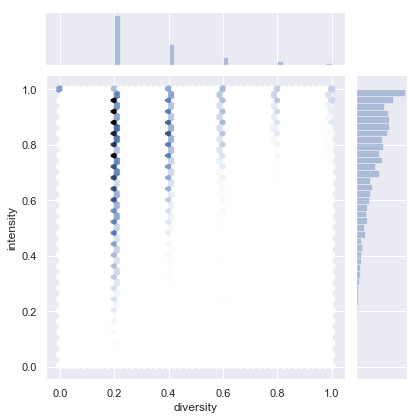

In [291]:
sns.set()

sns.jointplot(x='diversity', y='intensity', data=df, kind='hex')

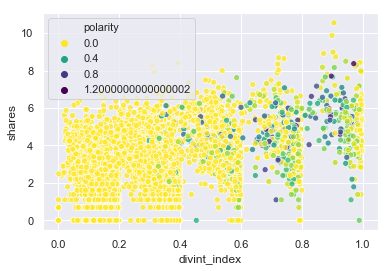

In [294]:
sns.scatterplot(x='divint_index', y=df['shares'].apply(np.log), hue='polarity', data=df, alpha=0.8, palette='viridis_r')
# sns.scatterplot(x='divint_index', y='intensity', hue='diversity', data=df, alpha=0.8, palette='viridis_r')

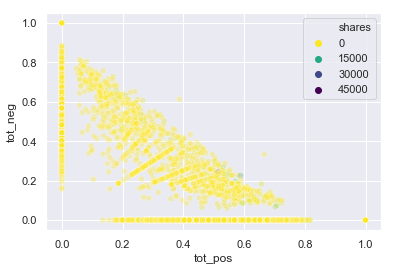

In [140]:
sns.scatterplot(x='tot_pos', y='tot_neg', hue='shares', data=df, alpha=0.3, palette='viridis_r')

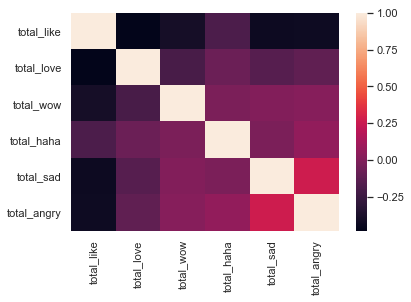

In [297]:
sns.heatmap(df[['total_like', 'total_love', 'total_wow', 'total_haha', 'total_sad', 'total_angry']].corr())